# 7 Qubit Error Detection Surface Code

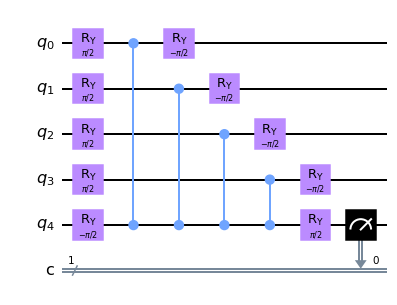

In [27]:
import numpy as np
import math
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

sc = QuantumCircuit(5,1)

sc.ry(pi/2,0)
sc.ry(pi/2,1)
sc.ry(pi/2,2)
sc.ry(pi/2,3)
sc.ry(-pi/2,4)

sc.cz(0,4)
sc.cz(1,4)
sc.cz(2,4)
sc.cz(3,4)

sc.ry(-pi/2,0)
sc.ry(-pi/2,1)
sc.ry(-pi/2,2)
sc.ry(-pi/2,3)
sc.ry(pi/2,4)

meas = QuantumCircuit(5,1)
meas.measure(4,0) #measure our ancilla qubits

circ = sc.compose(meas)

circ.draw('mpl')


In [28]:
backend = BasicAer.get_backend('qasm_simulator') #The device to run on
result = backend.run(transpile(circ,backend), shots = 1000).result()
counts = result.get_counts() #Get our result


print(counts)

{'0': 519, '1': 481}


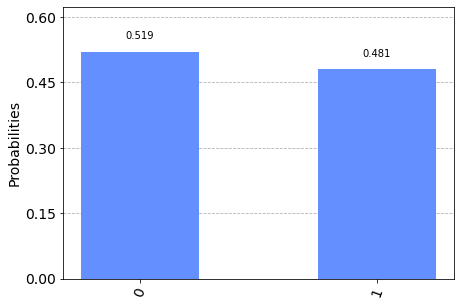

In [29]:
plot_histogram(counts)

In [30]:
from qiskit.quantum_info import Statevector
state = Statevector.from_int(0, 2**5) # Set the intial state of the simulator to the ground state using from_int
state = state.evolve(sc)# Evolve the state by the quantum circuit
state.draw('latex')

<IPython.core.display.Latex object>